In [1]:
import os
import json
import cv2
from matplotlib import pyplot as plt
from dataset import read_wider_meta

from utils import letterbox_pad

### Calculate and write meta

In [2]:
# data_root = './data/'

# # calculate
# train_meta = read_wider_meta(data_root, phase='train')
# val_meta = read_wider_meta(data_root, phase='val')
# test_meta = read_wider_meta(data_root, phase='test')

# with open('./data/train.json', 'w') as fwrite:
#     json.dump(train_meta, fwrite)
    
# with open('./data/val.json', 'w') as fwrite:
#     json.dump(val_meta, fwrite)

# with open('./data/test.json', 'w') as fwrite:
#     json.dump(test_meta, fwrite)

# Negative annotations found @ ./data/WIDER_train/images/54--Rescue/54_Rescue_rescuepeople_54_29.jpg
# Annotation: [1050, 142, -26, 50, 2, 0, 0, 0, 1, 0]
# Negative annotations found @ ./data/WIDER_train/images/7--Cheering/7_Cheering_Cheering_7_17.jpg
# Annotation: [0, 5, -11, 5, 0, 0, 0, 0, 0, 0]
# Negative annotations found @ ./data/WIDER_val/images/39--Ice_Skating/39_Ice_Skating_iceskiing_39_583.jpg
# Annotation: [1026, 474, -2, 23, 2, 0, 0, 0, 2, 0]

Negative annotations found @ ./data/WIDER_train/images/54--Rescue/54_Rescue_rescuepeople_54_29.jpg
Annotation: [1050, 142, -26, 50, 2, 0, 0, 0, 1, 0]

Negative annotations found @ ./data/WIDER_train/images/7--Cheering/7_Cheering_Cheering_7_17.jpg
Annotation: [0, 5, -11, 5, 0, 0, 0, 0, 0, 0]

Negative annotations found @ ./data/WIDER_val/images/39--Ice_Skating/39_Ice_Skating_iceskiing_39_583.jpg
Annotation: [1026, 474, -2, 23, 2, 0, 0, 0, 2, 0]



### Read meta

In [3]:
with open('./data/train.json', 'r') as fread:
    train_meta = json.load(fread)
    
with open('./data/val.json', 'r') as fread:
    val_meta = json.load(fread)
    
with open('./data/test.json', 'r') as fread:
    test_meta = json.load(fread)

### Dataset

In [4]:
# from torchvision.transforms import Compose
# from dataset import WIDERdataset, ToTensor

# %matplotlib inline

# val_transforms = Compose([
#     ToTensor()
# ])

# val_dataset = WIDERdataset('./data/val.json', 'val', 608, val_transforms)
# img, targets = val_dataset.__getitem__(1885, show_examples=True)

### Training loop

In [ ]:
from IPython.core.debugger import set_trace

from tqdm import tqdm
from time import sleep, strftime, localtime

import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import tensorboardX
from torchvision.transforms import Compose

from dataset import WIDERdataset, ToTensor
from darknet import Darknet

cfg_path = './cfg/yolov3_608x608_faces_only.cfg'
model_width = 608
batch_size = 4
shuffle = True
num_workers = 4
device = torch.device('cuda:0')
epoch_num = 100
curr_time = strftime('%m%d%H%M%S', localtime())
log_path = f'/home/nvme/logs/PP/B{batch_size}_{curr_time}'
lr = 3e-5

model = Darknet(cfg_path).to(device)

train_transforms = Compose([
    ToTensor()
])
val_transforms = Compose([
    ToTensor()
])
train_dataset = WIDERdataset(
    './data/train.json', 'train', model_width, train_transforms
)
val_dataset = WIDERdataset(
    './data/val.json', 'val', model_width, val_transforms
)
train_loader = DataLoader(
    train_dataset, batch_size, shuffle, num_workers=num_workers, 
    collate_fn=train_dataset.collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size * 3, num_workers=num_workers, 
    collate_fn=val_dataset.collate_fn
)

optimizer = Adam(model.parameters(), lr)

TBoard = tensorboardX.SummaryWriter(log_dir=log_path); print(f'saving log @ {log_path}')
# TBoard = None

# todo: normalize the inputs
model.train()

for epoch in range(epoch_num):
    ## TRAIN
    model.train()
    
    for i, (images, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.to(device)
        _, loss = model(images, targets[:, :6], device)
        loss.backward()
        optimizer.step()
        
        # logging
        step_num = epoch * len(train_loader) + i
        TBoard.add_scalar('train/loss', loss.item() / len(images), step_num)
        
    ## VALIDATION
    model.eval()
    val_total_loss = 0
    
    for i, (images, targets) in enumerate(tqdm(val_loader)):
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            prediction, loss = model(images, targets[:, :6], device)
            val_total_loss += loss.item()
        
    # logging
    val_total_loss /= len(val_loader)
    TBoard.add_scalar('val/loss', val_total_loss, step_num) # 472

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot


  0%|          | 0/3220 [00:00<?, ?it/s]

saving log @ /home/nvme/logs/PP/B4_0725220615


/home/esa/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  1%|          | 25/3220 [00:06<12:44,  4.18it/s]

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot


/home/esa/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.1 0.1


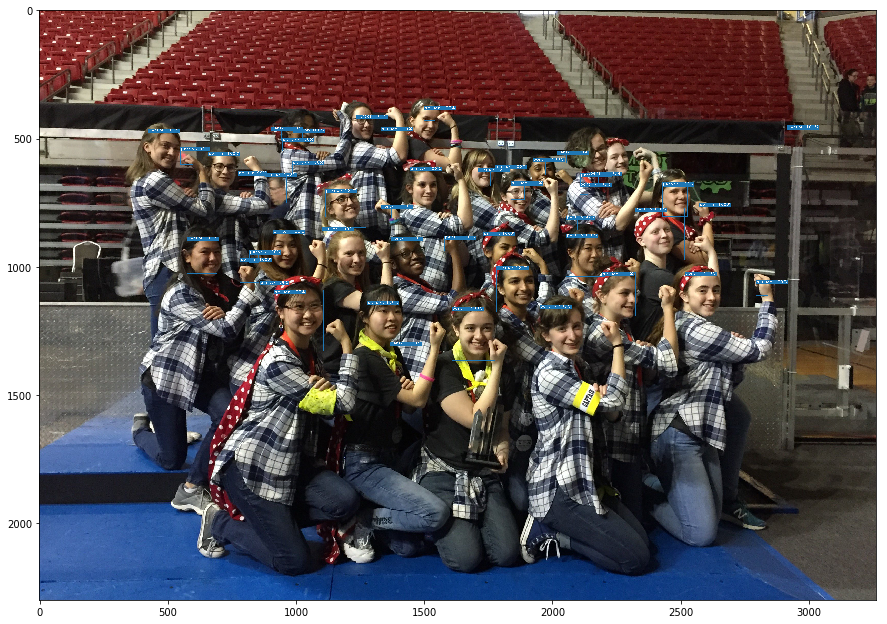

In [1]:
import torch

from utils import predict_and_save
from darknet import Darknet
%matplotlib inline

img_path = './databreakfast_spb.jpg'
img_path = './D211wP7WkAEaiPH.jpeg'
save_path = './output.jpg'
labels_path = './data/coco.names'
show = True
cfg_path = './cfg/yolov3_608x608_faces_only.cfg'
device = torch.device('cuda:0')
model_path = '/home/nvme/logs/PP/B4_0725211123/model_test.pt'

model = Darknet(cfg_path).to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)